In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import urllib
import csv
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

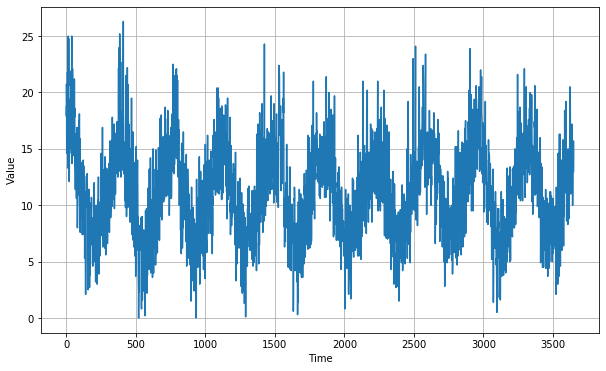

In [2]:
import requests
from contextlib import closing
import csv
time_step = []
temps = []

url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv'

with closing(requests.get(url, stream=True)) as r:
    f = (line.decode('utf-8') for line in r.iter_lines())
    reader = csv.reader(f, delimiter=',')
    next(reader)
    step=0
    for row in reader:
        temps.append(float(row[1]))
        time_step.append(step)
        step = step + 1

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [3]:
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [4]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [5]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [6]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)
Epoch 1/100
10/10 [==============================] - 4s 396ms/step - loss: 31.1551 - mae: 31.6551
Epoch 2/100
10/10 [==============================] - 2s 183ms/step - loss: 30.5849 - mae: 31.0783
Epoch 3/100
10/10 [==============================] - 2s 182ms/step - loss: 29.6259 - mae: 30.1792
Epoch 4/100
10/10 [==============================] - 2s 180ms/step - loss: 28.5432 - mae: 29.0582
Epoch 5/100
10/10 [==============================] - 2s 181ms/step - loss: 27.2554 - mae: 27.6970
Epoch 6/100
10/10 [==============================] - 2s 199ms/step - loss: 25.4769 - mae: 25.9975
Epoch 7/100
10/10 [==============================] - 2s 226ms/step - loss: 23.3469 - mae: 23.8407
Epoch 8/100
10/10 [==============================] - 2s 191ms/step - loss: 20.5459 - mae: 21.1120
Epoch 9/100
10/10 [==============================] - 2s 183ms/step - loss: 17.2022 - mae: 17.8083
Epoch 10/100
10/

10/10 [==============================] - 2s 248ms/step - loss: 4.6007 - mae: 5.0659
Epoch 84/100
10/10 [==============================] - 2s 248ms/step - loss: 5.1403 - mae: 5.6663
Epoch 85/100
10/10 [==============================] - 2s 243ms/step - loss: 5.5812 - mae: 6.1682
Epoch 86/100
10/10 [==============================] - 2s 247ms/step - loss: 11.4130 - mae: 11.1894
Epoch 87/100
10/10 [==============================] - 2s 242ms/step - loss: 12.6054 - mae: 13.5157
Epoch 88/100
10/10 [==============================] - 2s 234ms/step - loss: 31.5189 - mae: 32.1532
Epoch 89/100
10/10 [==============================] - 2s 237ms/step - loss: 44.2587 - mae: 43.1596
Epoch 90/100
10/10 [==============================] - 2s 244ms/step - loss: 25.7726 - mae: 26.7253
Epoch 91/100
10/10 [==============================] - 2s 235ms/step - loss: 51.3263 - mae: 52.9294
Epoch 92/100
10/10 [==============================] - 2s 225ms/step - loss: 55.0979 - mae: 53.6114
Epoch 93/100
10/10 [=========

[1e-08, 0.0001, 0, 60]

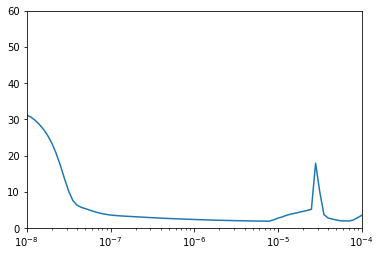

In [7]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [8]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150)

Epoch 1/150
25/25 [==============================] - 4s 167ms/step - loss: 9.9674 - mae: 10.5790
Epoch 2/150
25/25 [==============================] - 2s 97ms/step - loss: 2.5741 - mae: 3.0497
Epoch 3/150
25/25 [==============================] - 2s 98ms/step - loss: 1.9326 - mae: 2.3879: 1s - loss: 1.9920 - 
Epoch 4/150
25/25 [==============================] - 2s 93ms/step - loss: 1.8647 - mae: 2.3160
Epoch 5/150
25/25 [==============================] - 2s 92ms/step - loss: 1.8189 - mae: 2.2715
Epoch 6/150
25/25 [==============================] - 2s 94ms/step - loss: 1.7909 - mae: 2.2419
Epoch 7/150
25/25 [==============================] - 2s 94ms/step - loss: 1.7627 - mae: 2.2129
Epoch 8/150
25/25 [==============================] - 2s 94ms/step - loss: 1.7430 - mae: 2.1939
Epoch 9/150
25/25 [==============================] - 2s 94ms/step - loss: 1.7179 - mae: 2.1688
Epoch 10/150
25/25 [==============================] - 2s 94ms/step - loss: 1.6983 - mae: 2.1483
Epoch 11/150
25/25 [=====

Epoch 85/150
25/25 [==============================] - 3s 110ms/step - loss: 1.5041 - mae: 1.9471
Epoch 86/150
25/25 [==============================] - 3s 109ms/step - loss: 1.5033 - mae: 1.9455
Epoch 87/150
25/25 [==============================] - 3s 111ms/step - loss: 1.5027 - mae: 1.9446
Epoch 88/150
25/25 [==============================] - 3s 111ms/step - loss: 1.5041 - mae: 1.9454
Epoch 89/150
25/25 [==============================] - 3s 110ms/step - loss: 1.5003 - mae: 1.9434
Epoch 90/150
25/25 [==============================] - 3s 110ms/step - loss: 1.5021 - mae: 1.9428
Epoch 91/150
25/25 [==============================] - 3s 111ms/step - loss: 1.5016 - mae: 1.9442
Epoch 92/150
25/25 [==============================] - 3s 113ms/step - loss: 1.5012 - mae: 1.9435
Epoch 93/150
25/25 [==============================] - 3s 108ms/step - loss: 1.4983 - mae: 1.9405
Epoch 94/150
25/25 [==============================] - 3s 108ms/step - loss: 1.4974 - mae: 1.9392
Epoch 95/150
25/25 [==========

In [9]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

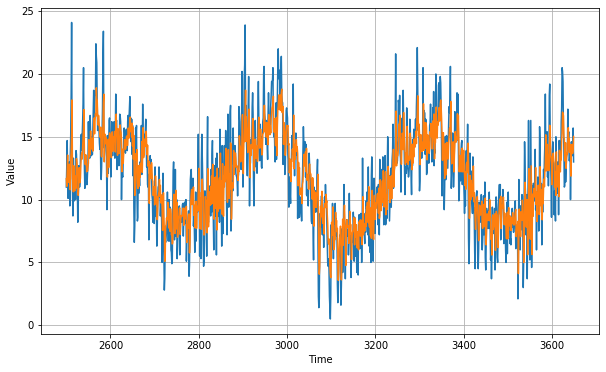

In [10]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [11]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

1.7814368

In [12]:
print(rnn_forecast)

[11.665927 11.050293 12.271805 ... 13.673017 13.806189 15.024006]
